In [6]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',100)

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

import itertools, math, time, re

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, ShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, auc, confusion_matrix, precision_score, recall_score, roc_curve, f1_score
from sklearn.preprocessing import MinMaxScaler, Normalizer

# Load Data

In [7]:
df = pd.read_csv('./data/sorted_df_14_15.csv', index_col=0)

In [8]:
# #change positions to numbered 1-5
# df.pos[df.pos=='PG'] = 1
# df.pos[df.pos=='SG'] = 2
# df.pos[df.pos=='SF'] = 3
# df.pos[df.pos=='PF'] = 4
# df.pos[df.pos=='C'] = 5

#convert negative touch times to 0
df.touch_time[df.touch_time<0] = 0
#combine all OT periods into one category
df.period = np.where(df.period>4, 5, df.period)

In [9]:
df.defender_name[df.defender_name=='0'] = 'None'

def convert_defender_names(player):
    if player =='None':
        return 'None'
    elif player=='Nene':
        return 'Nene'
    else:
        name = player.split(', ')
        full_name = ' '.join((name[1],name[0]))
        return re.sub(r'([^\s\w]|_)+', '', full_name)
    
df.defender_name = df.defender_name.apply(convert_defender_names)

# Clean up name discrepancies between two dfs
df.defender_name[df.defender_name=='Jose Juan Barea'] = 'JJ Barea'
df.defender_name[df.defender_name=='Tim Hardaway Jr'] = 'Tim Hardaway'
df.defender_name[df.defender_name=='Charles Hayes'] = 'Chuck Hayes'
df.defender_name[df.defender_name=='Glen Rice Jr'] = 'Glen Rice'
df.defender_name[df.defender_name=='Louis Williams'] = 'Lou Williams'

In [10]:
player_ids_df = df[['name','player_id']].rename(columns={'name':'defender_name','player_id':'defender_id'})
player_ids_df = player_ids_df.groupby('defender_name').max()

#create id for no defender (id=0) and append to player_ids_df
none_id = pd.DataFrame(data=[('None',0)],
                       columns=['defender_name','defender_id']).set_index('defender_name')
player_ids_df = pd.concat((player_ids_df,none_id))

df = df.merge(player_ids_df, on='defender_name')

In [11]:
#change dtypes
df[['pos','player_id','team_id','game_event_id','period','action_type','opp_id','defender_id',
    'shot_zone','shot_area']] = df[['pos','player_id','team_id','game_event_id','period','action_type',
                                    'opp_id','defender_id','shot_zone','shot_area']].astype('category')

df.game_date = pd.to_datetime(df.game_date)

In [12]:
#create dummies for period, shot_zone and shot_area
df = pd.concat([df,pd.get_dummies(df.period,prefix='q'),pd.get_dummies(df.shot_zone),
                pd.get_dummies(df.shot_area)],axis=1).drop(columns=['shot_zone','shot_area','period'])

In [13]:
df.head()

,name,pos,age,player_id,team_name,team_id,game_date,game_id,game_event_id,season,minutes_remaining,seconds_remaining,shot_made_flag,action_type,shot_type,shot_distance,x,y,dribbles,touch_time,opponent,opp_id,defender_name,defender_distance,shot_clock,lg_avg,htm,vtm,is_home,prev_shot_made,prev_2_made,prev_3_made,mid_R_pct,mid_C_pct,mid_L_pct,restricted_pct,heave_pct,ab_3_R_pct,ab_3_C_pct,ab_3_L_pct,paint_R_pct,paint_C_pct,paint_L_pct,corner_3_R_pct,corner_3_L_pct,defender_id,q_1,q_2,q_3,q_4,q_5,Above Break 3,Corner 3,Heave,Mid Range,Paint,Restricted Area,C,L,R
0,Aaron Gordon,PF,19,203932,Orlando Magic,10,2014-10-28,21400001,164,2014,11,34,1,Jump Shot,2,4,-10,44,4,5.1,New Orleans Pelicans,13,Ryan Anderson,3.9,0.6,0.4011,NOP,ORL,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,201583,0,1,0,0,0,0,0,0,0,1,0,1,0,0
1,Austin Rivers,SG,22,203085,Los Angeles Clippers,29,2015-01-30,21400701,104,2014,1,34,0,Jump Shot,3,26,-225,135,0,0.9,New Orleans Pelicans,13,Ryan Anderson,8.6,7.6,0.3438,NOP,LAC,0,0,0,0,0.3500,0.0714,0.4667,0.5052,0.0,0.2941,0.5,0.2917,0.4167,0.3448,0.3000,0.1111,0.4286,201583,1,0,0,0,0,1,0,0,0,0,0,0,0,1
2,Ben Gordon,SG,31,2732,Orlando Magic,10,2014-10-28,21400001,123,2014,2,0,0,Pullup Jump shot,2,10,-78,77,6,5.4,New Orleans Pelicans,13,Ryan Anderson,5.9,18.1,0.3844,NOP,ORL,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,201583,1,0,0,0,0,0,0,0,0,1,0,0,0,1
3,Dewayne Dedmon,C,25,203473,Orlando Magic,10,2015-02-20,21400803,78,2014,2,43,1,Driving Layup Shot,2,2,18,15,0,0.9,New Orleans Pelicans,13,Ryan Anderson,1.2,13.0,0.5999,ORL,NOP,1,0,0,0,1.0000,0.0000,0.0000,0.5970,0.0,0.0000,0.0,0.0000,0.3333,0.4286,0.3333,0.0000,0.0000,201583,1,0,0,0,0,0,0,0,0,0,1,1,0,0
4,Elfrid Payton,PG,20,203901,Orlando Magic,10,2015-02-20,21400803,434,2014,4,28,0,Driving Layup Shot,2,1,10,17,4,3.6,New Orleans Pelicans,13,Ryan Anderson,1.0,3.5,0.5999,ORL,NOP,1,1,1,1,0.4545,0.3333,0.3103,0.4978,0.0,0.6667,0.0,0.0909,0.5000,0.3210,0.4000,0.0000,1.0000,201583,0,0,0,1,0,0,0,0,0,0,1,1,0,0


### Merge adv defensive stats

In [14]:
stats = pd.read_excel('./data/adv-stats-14-15.xlsx').rename(columns={'Player': 'defender_name',
                                                                     'BLK%':'blk_pct',
                                                                     'DWS':'dws',
                                                                     'DBPM':'dbpm'})
defense_stats = stats.drop(columns=['Rk','Pos', 'Age', 'Tm', 'G', 'MP', 'PER', 'TS%', '3PAr', 'FTr',
       'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'TOV%', 'USG%', 'OWS','WS', 'WS/48', 'OBPM', 'BPM', 'VORP'])

defense_stats.defender_name = defense_stats.defender_name.apply(lambda x: re.sub(r'([^\s\w]|_)+', '',x))

defense_stats.defender_name[defense_stats.defender_name=='Nene Hilario'] = 'Nene'
defense_stats.defender_name[defense_stats.defender_name=='Jeffery Taylor'] = 'Jeff Taylor'
defense_stats.defender_name[defense_stats.defender_name== 'Luigi Datome'] = 'Gigi Datome'

In [15]:
#add dummy stats for no defender (id=0) and append to defense_stats
none_stats = pd.DataFrame(data=[('None',0,0,0)],
                       columns=['defender_name','blk_pct','dws','dbpm'])
defense_stats = pd.concat((defense_stats,none_stats)).reset_index(drop=True)


In [16]:
df = df.merge(defense_stats, on='defender_name')
df.head()

,name,pos,age,player_id,team_name,team_id,game_date,game_id,game_event_id,season,minutes_remaining,seconds_remaining,shot_made_flag,action_type,shot_type,shot_distance,x,y,dribbles,touch_time,opponent,opp_id,defender_name,defender_distance,shot_clock,lg_avg,htm,vtm,is_home,prev_shot_made,prev_2_made,prev_3_made,mid_R_pct,mid_C_pct,mid_L_pct,restricted_pct,heave_pct,ab_3_R_pct,ab_3_C_pct,ab_3_L_pct,paint_R_pct,paint_C_pct,paint_L_pct,corner_3_R_pct,corner_3_L_pct,defender_id,q_1,q_2,q_3,q_4,q_5,Above Break 3,Corner 3,Heave,Mid Range,Paint,Restricted Area,C,L,R,blk_pct,dws,dbpm
0,Aaron Gordon,PF,19,203932,Orlando Magic,10,2014-10-28,21400001,164,2014,11,34,1,Jump Shot,2,4,-10,44,4,5.1,New Orleans Pelicans,13,Ryan Anderson,3.9,0.6,0.4011,NOP,ORL,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,201583,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0.9,0.9,-3.1
1,Austin Rivers,SG,22,203085,Los Angeles Clippers,29,2015-01-30,21400701,104,2014,1,34,0,Jump Shot,3,26,-225,135,0,0.9,New Orleans Pelicans,13,Ryan Anderson,8.6,7.6,0.3438,NOP,LAC,0,0,0,0,0.3500,0.0714,0.4667,0.5052,0.0,0.2941,0.5,0.2917,0.4167,0.3448,0.3000,0.1111,0.4286,201583,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0.9,0.9,-3.1
2,Ben Gordon,SG,31,2732,Orlando Magic,10,2014-10-28,21400001,123,2014,2,0,0,Pullup Jump shot,2,10,-78,77,6,5.4,New Orleans Pelicans,13,Ryan Anderson,5.9,18.1,0.3844,NOP,ORL,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,201583,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0.9,0.9,-3.1
3,Dewayne Dedmon,C,25,203473,Orlando Magic,10,2015-02-20,21400803,78,2014,2,43,1,Driving Layup Shot,2,2,18,15,0,0.9,New Orleans Pelicans,13,Ryan Anderson,1.2,13.0,0.5999,ORL,NOP,1,0,0,0,1.0000,0.0000,0.0000,0.5970,0.0,0.0000,0.0,0.0000,0.3333,0.4286,0.3333,0.0000,0.0000,201583,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0.9,0.9,-3.1
4,Elfrid Payton,PG,20,203901,Orlando Magic,10,2015-02-20,21400803,434,2014,4,28,0,Driving Layup Shot,2,1,10,17,4,3.6,New Orleans Pelicans,13,Ryan Anderson,1.0,3.5,0.5999,ORL,NOP,1,1,1,1,0.4545,0.3333,0.3103,0.4978,0.0,0.6667,0.0,0.0909,0.5000,0.3210,0.4000,0.0000,1.0000,201583,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0.9,0.9,-3.1


In [17]:
# #re-sort columns
# df = df[['name', 'pos', 'age', 'player_id', 'team_name', 'team_id', 'game_date',
#        'game_id', 'game_event_id', 'season', 'period', 'minutes_remaining',
#        'seconds_remaining', 'shot_made_flag', 'action_type', 'shot_type',
#        'shot_distance', 'x', 'y', 'dribbles', 'touch_time', 'shot_clock', 'opponent',
#        'opp_id', 'defender_name','defender_id', 'defender_distance', 'blk_pct','dws','dbpm',
#        'shot_zone', 'shot_area', 'lg_avg', 'htm', 'vtm', 'is_home',
#        'prev_shot_made', 'prev_2_made', 'prev_3_made']]

# Model Architecture and Metrics

#### Model Architecture

In [18]:
def build_model(model, X_train, X_test, y_train, y_test, decision_function=True):
    start = time.time()
    
    clf = model
    clf.fit(X_train,y_train)  
    y_hat_test = clf.predict(X_test)
      
    if decision_function==True:
        y_score = clf.decision_function(X_test)
    else:
        y_score = clf.predict_proba(X_test)[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    print('Total Runtime: {} seconds'.format(time.time()-start))
    
    return clf, y_hat_test, y_score, fpr, tpr, thresholds

#### Feature Importance

In [19]:
def plot_feature_importances(model):
    matplotlib.style.use('fivethirtyeight')
    n_features = len(X.columns)
    plt.figure(figsize=(14,10))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Features")

#### Confusion Matrix

In [34]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    #Create the basic matrix.
    plt.imshow(cm, cmap)
    
    #Add title and Axis Labels
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    #Add appropriate Axis Scales
    class_names = ['Miss','Make']
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    
    #Add Labels to Each Cell
    thresh = cm.max()*.75
    
    #Add a Side Bar Legend Showing Colors
    plt.colorbar()
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

#### Metrics Printout

In [21]:
def print_model_metrics(y_pred,y_score):
    cm = confusion_matrix(y_test, y_pred)
    #print(cm)
    true_negative, false_positive, false_negative, true_positive = cm[0,0], cm[0,1], cm[0,1], cm[0,1]

    plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues)

    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    #print('Training Set Metrics:')
    print('Accuracy:   {}'.format(round(accuracy,4)))
    print('Precision:  {}'.format(round(precision,4)))
    print('Recall:     {}'.format(round(recall,4)))
    print('F1          {}'.format(round(f1,4)))
    print('AUC:        {}'.format(round(auc(fpr, tpr),4)))

#### ROC Curve Plot

In [22]:
def plot_roc_curve(fpr, tpr):
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    plt.figure(figsize=(10,6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# GridSearch Parameter Tuning

## Train Test split and Normalize Data

In [23]:
X = df.drop(columns=['name','age','pos','player_id','team_id','opp_id','team_name','game_date','opponent',
                     'defender_name','game_id','action_type','season','htm', 'vtm','game_event_id',
                     'minutes_remaining','seconds_remaining','defender_id','shot_type',
                     'shot_made_flag'])
y = df.shot_made_flag

In [24]:
# minmax_scale = MinMaxScaler()
# X_scaled = minmax_scale.fit_transform(X)

In [25]:
# ss = StratifiedKFold(n_splits=10, shuffle=True, random_state=23)
# for train_index, test_index in ss.split(X_scaled, y):
#     print("Train:", train_index, "Validation:", test_index) 
#     X_train, X_test = X_scaled[train_index], X_scaled[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [26]:
# cross_val_score(ss,X,)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=23)

## Logistic Regression

In [28]:
log_reg, log_y_preds, log_y_score, log_fpr, log_tpr, log_thresholds= build_model(LogisticRegression(
                                                                                C=1, class_weight='balanced'),
                                                                                X_train, X_test,
                                                                                y_train, y_test)

Total Runtime: 7.9807868003845215 seconds


Accuracy:   0.6103
Precision:  0.568
Recall:     0.5412
F1          0.5543
AUC:        0.6462


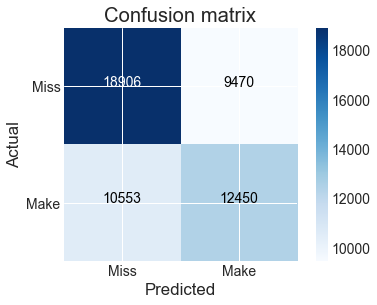

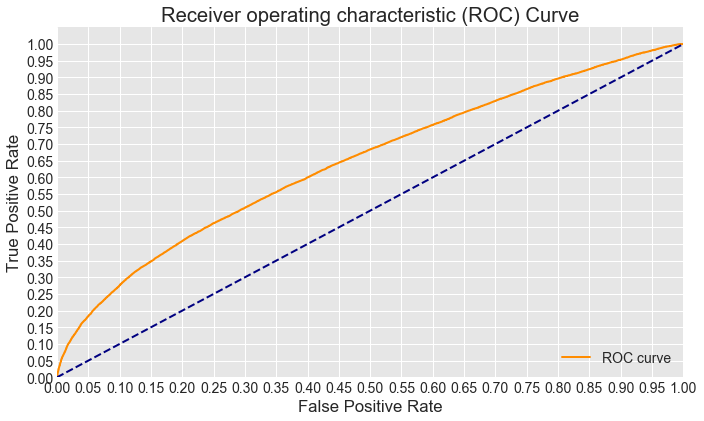

In [35]:
print_model_metrics(log_y_preds, log_y_score)
plot_roc_curve(log_fpr, log_tpr)

# Test Set Metrics:
# Accuracy:   0.6108
# Precision:  0.569
# Recall:     0.5385
# F1          0.5533
# AUC:        0.6464

# Training Set Metrics:
# Accuracy:   0.6092
# Precision:  0.5689
# Recall:     0.538
# F1          0.553
# AUC:        0.6449

# Random Forest Classifier

In [30]:
rf, rf_y_preds, rf_y_score, rf_fpr, rf_tpr, rf_thresholds = build_model(RandomForestClassifier(
                                                                        n_estimators=50, criterion='gini',
                                                                        max_features='sqrt',min_samples_leaf=10,
                                                                        min_samples_split=10, verbose=1,
                                                                        class_weight='balanced',n_jobs=2,
                                                                        random_state=23),
                                                                        X_train, X_test, y_train, y_test,
                                                                        decision_function=False)


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   18.2s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   19.4s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.4s finished


Total Runtime: 20.723031044006348 seconds


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.5s finished


In [37]:
rf

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=10,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=2, oob_score=False, random_state=23,
            verbose=1, warm_start=False)

Accuracy:   0.6594
Precision:  0.6407
Recall:     0.5445
F1          0.5887
AUC:        0.7125


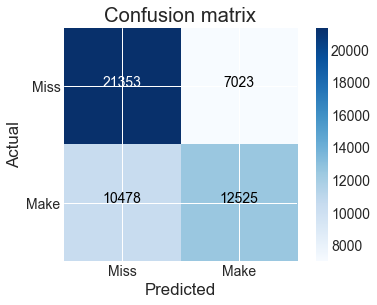

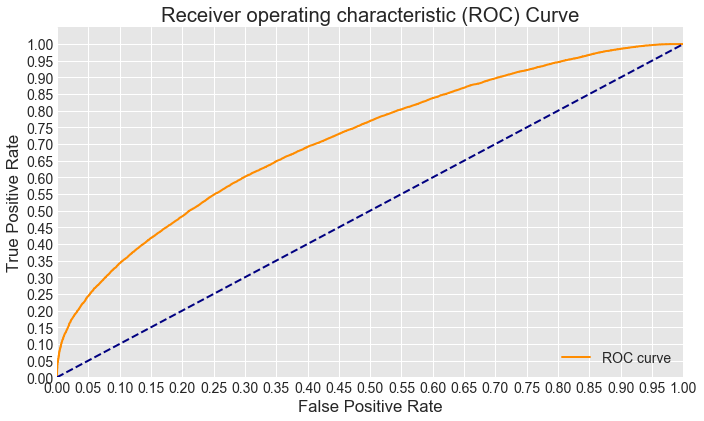

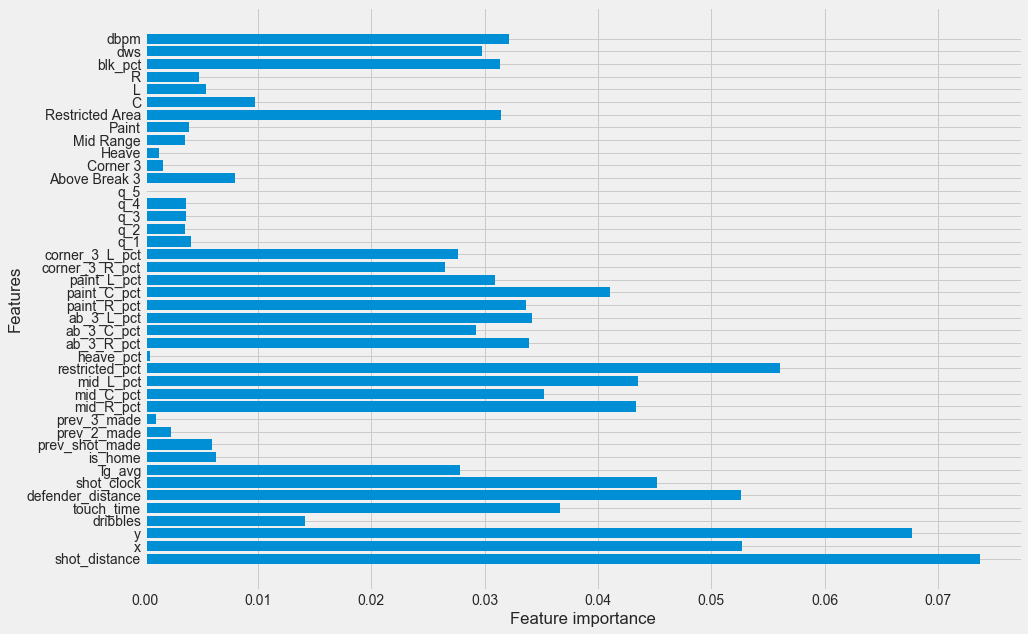

In [36]:
print_model_metrics(rf_y_preds, rf_y_score)
plot_roc_curve(rf_fpr, rf_tpr)
plot_feature_importances(rf)

# Test Set Metrics:
# Accuracy:   0.6559
# Precision:  0.6364
# Recall:     0.5396
# F1          0.584
# AUC:        0.7125

# Training Set Metrics:
# Accuracy:   0.8714
# Precision:  0.8679
# Recall:     0.8419
# F1          0.8547
# AUC:        0.9442

# Gradient Boosting Classifier

In [691]:
gb, gb_y_preds, gb_y_score, gb_fpr, gb_tpr, gb_thresholds = build_model(GradientBoostingClassifier(
                                                                        learning_rate=.1, n_estimators=100, 
                                                                        max_depth=5, min_samples_leaf=5,
                                                                        min_samples_split=5, verbose=1, 
                                                                        random_state=23),
                                                                        X_train, X_test, y_train, y_test)

      Iter       Train Loss   Remaining Time 
         1           1.3582            2.77m
         2           1.3438            2.36m
         3           1.3319            2.14m
         4           1.3209            2.06m
         5           1.3126            1.98m
         6           1.3044            1.93m
         7           1.2981            1.87m
         8           1.2927            1.84m
         9           1.2881            1.84m
        10           1.2830            1.87m
        20           1.2559            1.78m
        30           1.2396            1.52m
        40           1.2298            1.39m
        50           1.2206            1.11m
        60           1.2133           53.80s
        70           1.2072           40.01s
        80           1.2020           26.09s
        90           1.1963           12.75s
       100           1.1922            0.00s
Total Runtime: 126.9250476360321 seconds


Accuracy:   0.6605
Precision:  0.6976
Recall:     0.4267
F1          0.5295
AUC:        0.7169


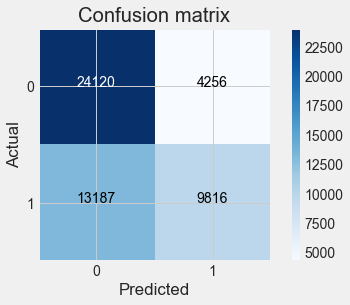

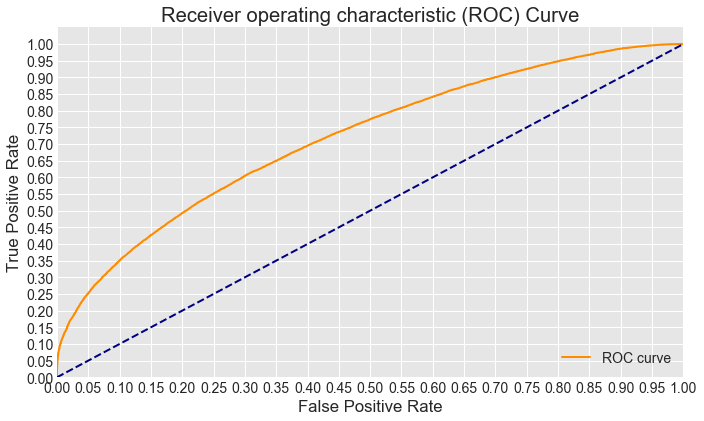

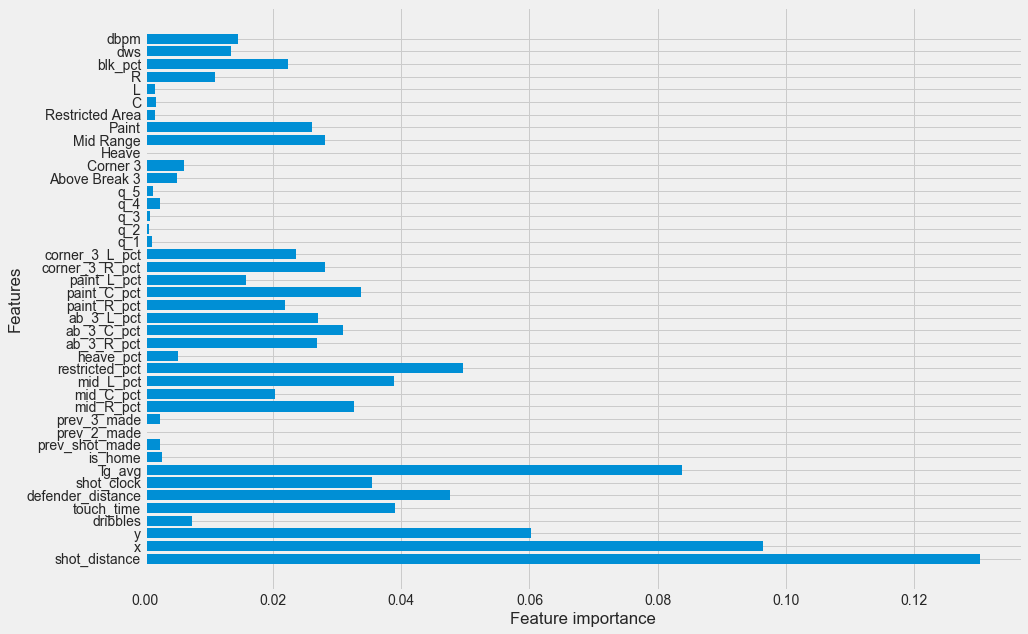

In [692]:
print_model_metrics(gb_y_preds, gb_y_score)
plot_roc_curve(gb_fpr, gb_tpr)
plot_feature_importances(gb)

# Test Set Metrics:
# Accuracy:   0.6605
# Precision:  0.6976
# Recall:     0.4267
# F1          0.5295
# AUC:        0.7169

# Training Set Metrics:
# Accuracy:   0.6696
# Precision:  0.7172
# Recall:     0.4371
# F1          0.5432
# AUC:        0.7356

# AdaBoost Classifier

In [693]:
ada, ada_y_preds, ada_y_score, ada_fpr, ada_tpr, ada_thresholds = build_model(AdaBoostClassifier(
                                                                        learning_rate=1, n_estimators=100, 
                                                                        algorithm='SAMME.R', random_state=23),
                                                                        X_train, X_test, y_train, y_test)

Total Runtime: 30.02020812034607 seconds


Accuracy:   0.6377
Precision:  0.6506
Recall:     0.4122
F1          0.5046
AUC:        0.6623


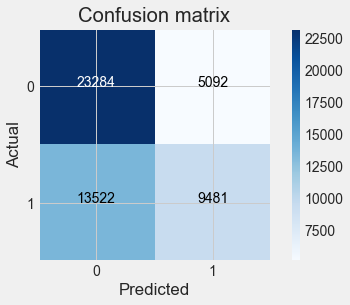

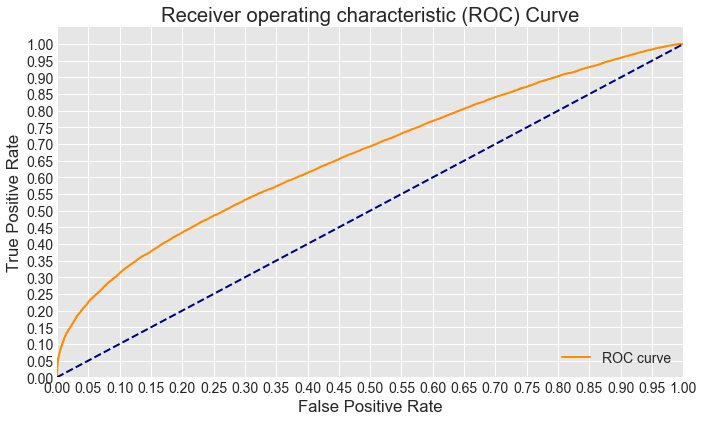

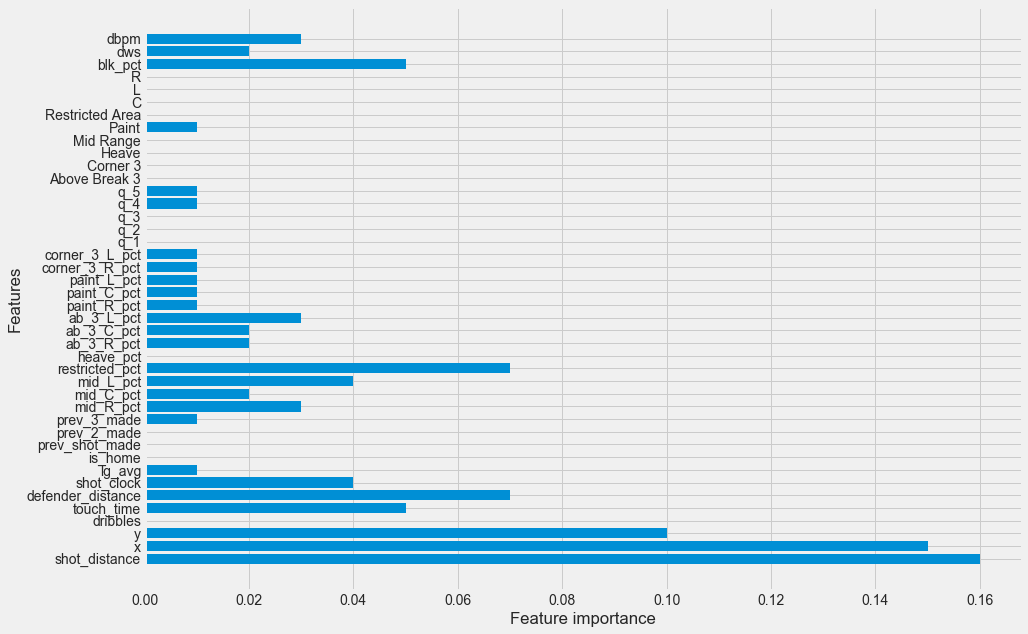

In [694]:
print_model_metrics(ada_y_preds, ada_y_score)
plot_roc_curve(ada_fpr, ada_tpr)
plot_feature_importances(ada)

# Test Set Metrics:
# Accuracy:   0.6377
# Precision:  0.6506
# Recall:     0.4122
# F1          0.5046
# AUC:        0.6623

# Training Set Metrics:
# Accuracy:   0.6347
# Precision:  0.6477
# Recall:     0.4102
# F1          0.5023
# AUC:        0.6632